In [1]:
!pip install python-mnist
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

fetching http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
fetching http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
fetching http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
fetching http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:

x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.0000))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x):
    return x.view(-1,1,28,28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
run.fit(5,learn)

train: [1.4918592447916668, tensor(0.5113)]
valid: [0.400771728515625, tensor(0.8749)]
train: [0.24664484049479166, tensor(0.9262)]
valid: [0.217200830078125, tensor(0.9340)]
train: [0.15350589192708333, tensor(0.9540)]
valid: [0.1248635009765625, tensor(0.9591)]
train: [0.105885595703125, tensor(0.9689)]
valid: [0.1198818359375, tensor(0.9630)]
train: [0.10406144205729166, tensor(0.9684)]
valid: [0.1485833740234375, tensor(0.9541)]


In [15]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [16]:

class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [17]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [18]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [19]:
cbfs.append(CudaCallback)

In [20]:
model = get_cnn_model(data)

In [21]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [1.5480516927083334, tensor(0.4679, device='cuda:0')]
valid: [0.572332470703125, tensor(0.8212, device='cuda:0')]
train: [0.2676329915364583, tensor(0.9194, device='cuda:0')]
valid: [0.2064484619140625, tensor(0.9372, device='cuda:0')]
train: [0.145635595703125, tensor(0.9554, device='cuda:0')]
valid: [0.1087627197265625, tensor(0.9649, device='cuda:0')]
CPU times: user 4.59 s, sys: 1.1 s, total: 5.69 s
Wall time: 6.44 s


In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [24]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [25]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [26]:
nfs = [8,16,32,32]

In [27]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [28]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [29]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)


In [30]:
run.fit(3,learn)

train: [2.1207088541666668, tensor(0.2347, device='cuda:0')]
valid: [1.01188017578125, tensor(0.6756, device='cuda:0')]
train: [0.46139069010416667, tensor(0.8543, device='cuda:0')]
valid: [0.1906006591796875, tensor(0.9403, device='cuda:0')]
train: [0.16816549479166668, tensor(0.9494, device='cuda:0')]
valid: [0.2182203369140625, tensor(0.9340, device='cuda:0')]


In [32]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [33]:
model = SequentialModel(*get_cnn_layers(data,nfs))
learn,run = get_runner(model,data,lr = 0.9,cbs = cbfs)

In [34]:
run.fit(2,learn)

train: [1.8248759114583333, tensor(0.3487, device='cuda:0')]
valid: [0.921046875, tensor(0.7059, device='cuda:0')]
train: [0.3606046875, tensor(0.8907, device='cuda:0')]
valid: [0.2158894775390625, tensor(0.9363, device='cuda:0')]


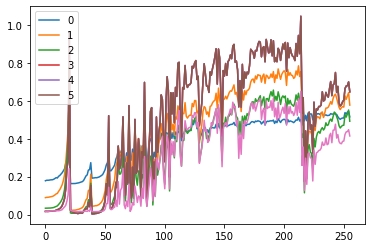

In [39]:
for l in model.act_means: 
    plt.plot(l)
plt.legend(range(6))


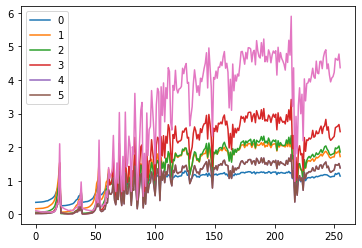

In [41]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(6))

In [43]:

model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [45]:

act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [46]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [47]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [48]:
run.fit(1,learn)

train: [1.6230444010416667, tensor(0.4435, device='cuda:0')]
valid: [0.657596826171875, tensor(0.8210, device='cuda:0')]


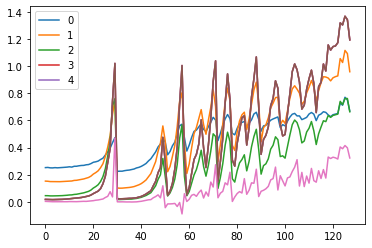

In [49]:

for o in act_means: plt.plot(o)
plt.legend(range(5));

In [50]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [51]:
model = get_cnn_model(data,nfs)
learn,run = get_runner(model,data,lr = 0.5,cbs = cbfs)

In [52]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [53]:
run.fit(1, learn)

train: [1.7841489583333334, tensor(0.3727, device='cuda:0')]
valid: [0.788225830078125, tensor(0.7778, device='cuda:0')]


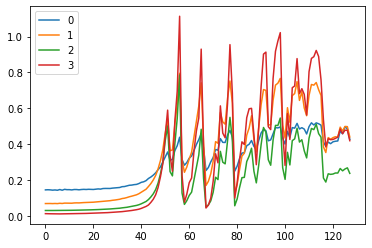

In [67]:

for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

In [68]:

#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [69]:

ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [70]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [74]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [75]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [76]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [77]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f112d28aeb0>, <__main__.Hook object at 0x7f112d0aae80>, <__main__.Hook object at 0x7f112dc088b0>, <__main__.Hook object at 0x7f112d0b7490>, <__main__.Hook object at 0x7f112d0b7070>, <__main__.Hook object at 0x7f112d0b7040>, <__main__.Hook object at 0x7f112d0b7280>]

In [78]:
hooks.remove()

In [79]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [80]:
x.mean(),x.std()

(tensor(-0.0021, device='cuda:0'), tensor(0.9970, device='cuda:0'))

In [81]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2435, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2353, device='cuda:0', grad_fn=<StdBackward0>))

In [82]:

for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()